# Test Code Analysis

In [1]:
import re
import os
from tree_sitter import Language, Parser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

lang = Language('lang/tree-sitter-languages.so', 'java')
parser = Parser()
parser.set_language(lang)

## Extract assertions for test methods

In [2]:
df = pd.DataFrame(columns=['file', 'test_method', 'assertion_count', 'assertion_list', 'comment_count', 'comment_list'])

def find_test_methods(tree, source_code):
    test_methods = []

    for node in tree.root_node.children:
        if node.type == 'class_declaration':
            for class_child in node.children:
                if class_child.type == 'class_body':
                    for class_body_child in class_child.children:
                        if class_body_child.type == 'method_declaration':
                            for method_child in class_body_child.children:
                                if method_child.type == 'modifiers' and '@Test' in method_child.text.decode('utf-8'):
                                        test_methods.append(class_body_child.text.decode('utf-8'))

    return test_methods


def find_assertions(method_code):
    assertion_count = 0
    assertion_list = []

    # Use regular expression to find method calls starting with "assert"
    assertions = re.findall(r'assert\w*\s*\(.*?\);', method_code)
    assertions_fail = re.findall(r'fail\w*\s*\(.*?\);', method_code)
    assertions = assertions + assertions_fail
    for assertion in assertions:
        # Extract the assertion method name
        method_name = assertion.split('(')[0].strip()
        assertion_list.append(method_name)
        assertion_count += 1

    return assertion_count, assertion_list


def find_comments(method_code):
    comment_pattern = r'(/\*[\s\S]*?\*/|//.*?$)'
    comments = re.findall(comment_pattern, method_code, re.MULTILINE)
    comment_count = len(comments)
    return comment_count, comments

java_files_dir = 'tests'

# Iterate through Java files
for root, dirs, files in os.walk(java_files_dir):
    for file in files:
        if file.endswith('.java'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                source_code = f.read()
            tree = parser.parse(source_code.encode())
            test_methods = find_test_methods(tree, source_code)
            for method in test_methods:
                assertion_count, assertion_list = find_assertions(method)
                comment_count, comments = find_comments(method)
                # insert into dataframe
                df = df._append({'file': file, 'test_method': method, 'assertion_count': assertion_count,
                                'assertion_list': assertion_list, 'comment_count': comment_count, 'comment_list': comments}, ignore_index=True)
            if not test_methods:
                df = df._append({'file': file, 'test_method': 'None', 'assertion_count': 0,
                                'assertion_list': [], 'comment_count': 0, 'comment_list': []}, ignore_index=True)

In [3]:
df_include_none = df.copy()
df = df[df.test_method != 'None']

## Plot results

In [4]:
# put assertion counts into bins
df_bins_helper = pd.cut(df['assertion_count'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 40], include_lowest=True, right=False)

In [5]:
df_bins_value_counts = df_bins_helper.value_counts().sort_index()

In [6]:
# rename index
df_bins_value_counts.index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10-14', '15-39']

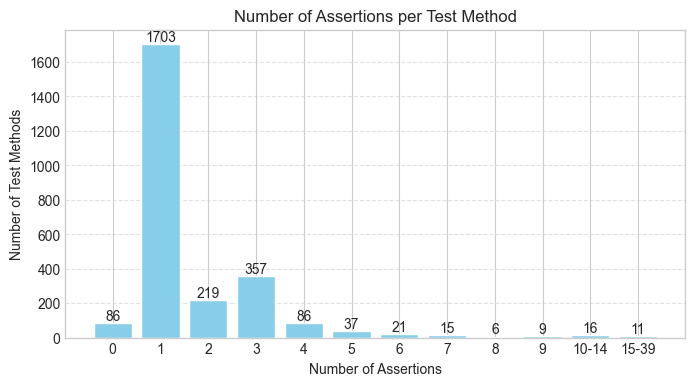

In [7]:
plt.figure(figsize=(8, 4))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.bar(df_bins_value_counts.index, df_bins_value_counts.values, color='skyblue')
plt.bar_label(bar)
plt.xlabel('Number of Assertions')
plt.ylabel('Number of Test Methods')
plt.title('Number of Assertions per Test Method')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('img/assertion_counts.pdf', dpi=300, bbox_inches='tight')
plt.show()

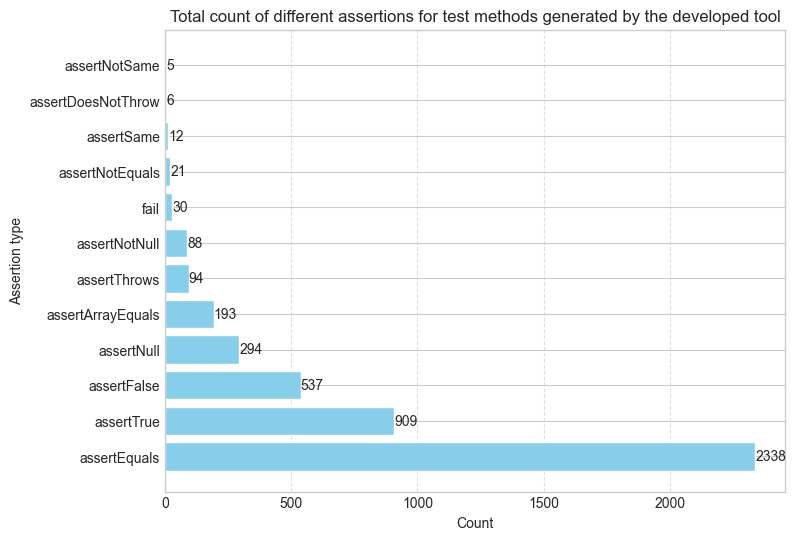

In [8]:
# plot type of assertions as bar chart
# Flatten the list of assertions into a single list
all_assertions = [assertion for assertions in df['assertion_list'] for assertion in assertions]

# Count the occurrences of each assertion
assertion_counts = {assertion: all_assertions.count(assertion) for assertion in set(all_assertions)}

# Create a DataFrame for plotting
assertion_df = pd.DataFrame(list(assertion_counts.items()), columns=['Assertion', 'Count'])

# Sort the DataFrame by count (optional)
assertion_df = assertion_df.sort_values(by='Count', ascending=False)

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.barh(assertion_df['Assertion'], assertion_df['Count'], color='skyblue')
plt.bar_label(bar)
plt.xlabel('Count')
plt.ylabel('Assertion type')
plt.title('Total count of different assertions for test methods generated by the developed tool')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('img/assertion_types.pdf', dpi=300, bbox_inches='tight')
plt.show()

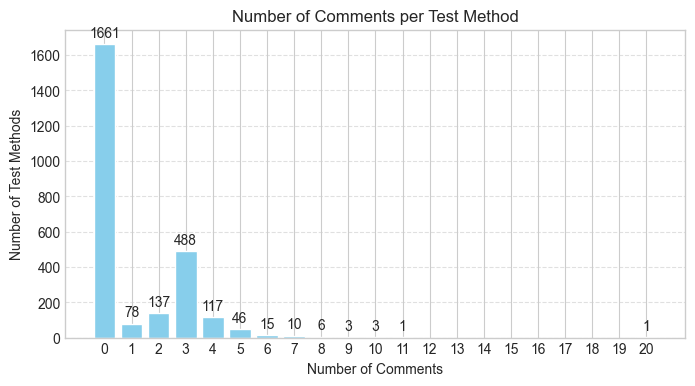

In [9]:
plt.figure(figsize=(8, 4))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.bar(df['comment_count'].value_counts().index, df['comment_count'].value_counts().values, color='skyblue')
plt.bar_label(bar, padding=3)
plt.xticks(np.arange(0, 21, 1))
plt.xlabel('Number of Comments')
plt.ylabel('Number of Test Methods')
plt.title('Number of Comments per Test Method')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('img/comment_counts.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
df_include_none[df_include_none['test_method'] == 'None'].count()

file               2
test_method        2
assertion_count    2
assertion_list     2
comment_count      2
comment_list       2
dtype: int64

In [11]:
df_file = df.groupby('file').count().value_counts().reset_index().rename(columns={0: 'count'})._append({'test_method': 0, 'count': 2}, ignore_index=True)

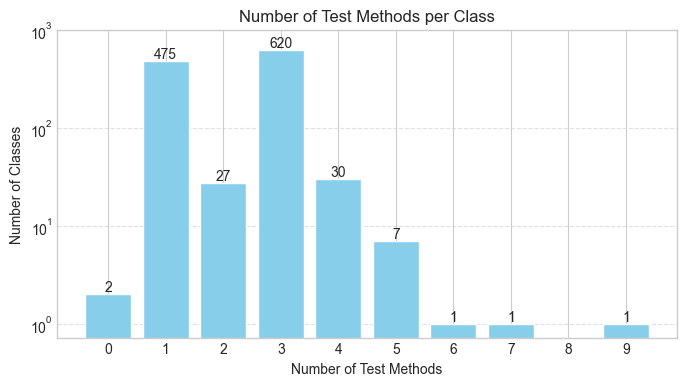

In [12]:
# analyze number of test cases per file
plt.figure(figsize=(8, 4))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.bar(df_file.test_method, df_file['count'], color='skyblue')
plt.bar_label(bar)
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Number of Test Methods')
plt.ylabel('Number of Classes')
plt.title('Number of Test Methods per Class')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('img/test_methods_per_class.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Analyze Evosuite 30 runs

In [13]:
evosuite_tests = {}

for i in range(1, 31):
    temp = []
    # get all files in evosuite_runs/test_i that end with ESTest.java
    for root, dirs, files in os.walk(f'evosuite_runs/tests_{i}'):
        for file in files:
            if file.endswith('ESTest.java'):
                temp.append(os.path.join(root, file))
    evosuite_tests[i] = temp

In [14]:
evosuite_tests_eval = pd.DataFrame(columns=['run', 'file', 'test_method', 'assertion_count', 'assertion_list'])

for i in range(1, 31):
    for file_path in evosuite_tests[i]:
        with open(file_path, 'r', encoding='utf-8') as f:
                    source_code = f.read()
        tree = parser.parse(source_code.encode())
        test_methods = find_test_methods(tree, source_code)
        for method in test_methods:
            assertion_count, assertion_list = find_assertions(method)
            # insert into dataframe
            evosuite_tests_eval = evosuite_tests_eval._append({'run': i, 'file': file, 'test_method': method, 'assertion_count': assertion_count,
                            'assertion_list': assertion_list}, ignore_index=True)

#### Test Methods per run

In [15]:
evosuite_tests_eval['run'].value_counts().mean()

541.0666666666667

#### Assertion count

In [16]:
evosuite_tests_eval_bins = pd.cut(evosuite_tests_eval['assertion_count'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 150, 200, 300], include_lowest=True, right=False)

In [17]:
evosuite_tests_eval_bins = evosuite_tests_eval_bins.value_counts().sort_index()

In [18]:
# rename index
evosuite_tests_eval_bins.index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10-19', '20-49', '50-99', '100-149', '150-199', '200-299']

In [19]:
evosuite_tests_eval_bins

0           1390
1          11323
2           1775
3            564
4            175
5             41
6             14
7              1
8             91
9             16
10-19        171
20-49        355
50-99        204
100-149       71
150-199       30
200-299       11
Name: count, dtype: int64

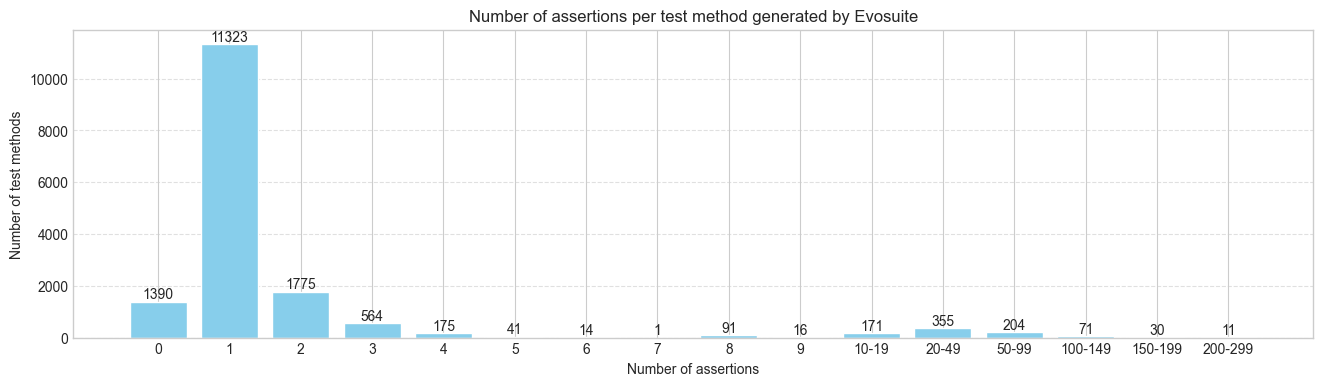

In [20]:
plt.figure(figsize=(16, 4))
plt.style.use('seaborn-v0_8-whitegrid')
# change space between bars
bar = plt.bar(evosuite_tests_eval_bins.index, evosuite_tests_eval_bins.values, color='skyblue')
plt.bar_label(bar)
plt.xlabel('Number of assertions')
plt.ylabel('Number of test methods')
plt.title('Number of assertions per test method generated by Evosuite')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('img/assertion_counts_evosuite.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Assertion types

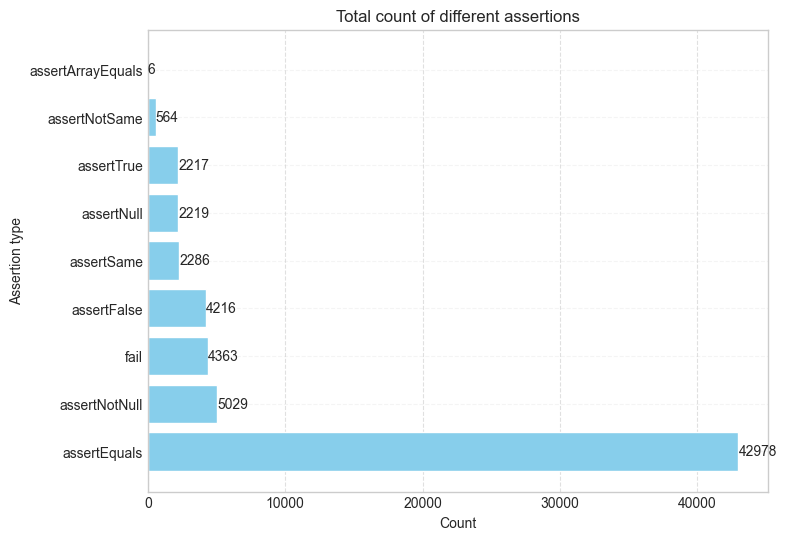

In [21]:
all_assertions = [assertion for assertions in evosuite_tests_eval['assertion_list'] for assertion in assertions]

# Count the occurrences of each assertion
assertion_counts = {assertion: all_assertions.count(assertion) for assertion in set(all_assertions)}

# Create a DataFrame for plotting
assertion_df = pd.DataFrame(list(assertion_counts.items()), columns=['Assertion', 'Count'])

# Sort the DataFrame by count (optional)
assertion_df = assertion_df.sort_values(by='Count', ascending=False)

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-whitegrid')
bar = plt.barh(assertion_df['Assertion'], assertion_df['Count'], color='skyblue')
plt.bar_label(bar)
plt.xlabel('Count')
plt.ylabel('Assertion type')
plt.title('Total count of different assertions')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.savefig('img/assertion_types_evosuite.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Comparision

#### Line numbers per test method

In [22]:
# get line number of test methods statistics
df['line_number'] = df['test_method'].apply(lambda x: len(x.split('\n'))-3)
evosuite_tests_eval['line_number'] = evosuite_tests_eval['test_method'].apply(lambda x: len(x.split('\n'))-3)

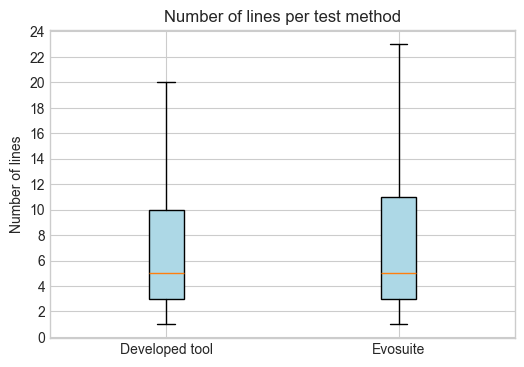

In [23]:
# create boxplot of line_number from df and df_evosuite
plt.figure(figsize=(6, 4))
plt.style.use('seaborn-v0_8-whitegrid')
plt.boxplot([df['line_number'], evosuite_tests_eval['line_number']], labels=['Developed tool', 'Evosuite'], showfliers=False, boxprops=dict(facecolor='lightblue'), patch_artist = True)
plt.yticks(np.arange(0, 26, 2))
plt.ylabel('Number of lines')
plt.title('Number of lines per test method')
plt.savefig('img/line_number_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
for i, r in evosuite_tests_eval[evosuite_tests_eval['assertion_count'] == 0].head(10).iterrows():
    print(r['test_method'])
    print('------------------')

@Test(timeout = 4000)
  public void test1()  throws Throwable  {
      List<String> list0 = List.of("org.apache.commons.cli.ParseException", "org.apache.commons.cli.UnrecognizedOptionException");
      AmbiguousOptionException ambiguousOptionException0 = new AmbiguousOptionException("org.apache.commons.cli.ParseException", list0);
  }
------------------
@Test(timeout = 4000)
  public void test3()  throws Throwable  {
      LinkedList<Object> linkedList0 = new LinkedList<Object>();
      List<Object> list0 = List.of((Object) linkedList0, (Object) linkedList0);
      MissingOptionException missingOptionException0 = new MissingOptionException(list0);
  }
------------------
@Test(timeout = 4000)
  public void test00()  throws Throwable  {
      HelpFormatter helpFormatter0 = new HelpFormatter();
      MockFile mockFile0 = new MockFile("usage: ");
      MockPrintWriter mockPrintWriter0 = new MockPrintWriter(mockFile0);
      helpFormatter0.printWrapped((PrintWriter) mockPrintWriter0, 11, ""

In [25]:
df

,file,test_method,assertion_count,assertion_list,comment_count,comment_list,line_number
0,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionToEmptyGro...,2,"[assertEquals, assertEquals]",0,[],5
1,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionToNonEmpty...,3,"[assertEquals, assertTrue, assertTrue]",0,[],8
2,OptionGroupTest_Method_18_Run_20231030_094427....,@Test\n public void testAddOptionWithDuplic...,2,"[assertEquals, assertEquals]",0,[],7
3,OptionsTest_Method_8_Run_20231024_091429.java,@Test\n public void testGetOptionShortName(...,1,[assertEquals],3,[// Create a mock Option object with a short n...,11
4,OptionsTest_Method_8_Run_20231024_091429.java,@Test\n public void testGetOptionLongName()...,1,[assertEquals],3,[// Create a mock Option object with a long na...,11
...,...,...,...,...,...,...,...
2563,CommandLineTest_Method_134_Run_20231023_214133...,@Test\n public void testGetOptionProperties...,1,[assertEquals],0,[],5
2564,CommandLineTest_Method_134_Run_20231023_214133...,@Test\n public void testGetOptionProperties...,1,[assertEquals],0,[],5
2565,HelpFormatterTest_Method_206_Run_20231025_1050...,@Test\n void testSetArgNameValidString() {\...,1,[assertEquals],0,[],3
2566,HelpFormatterTest_Method_206_Run_20231025_1050...,@Test\n void testSetArgNameNull() {\n ...,1,[assertNull],0,[],3


In [26]:
df_include_none[df_include_none['test_method'] == 'None']

,file,test_method,assertion_count,assertion_list,comment_count,comment_list
2341,CommandLineTest_Method_143_Run_20231027_212614...,None,0,[],0,[]
2427,UtilTest_Method_61_Run_20231024_145023.java,None,0,[],0,[]
